In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import cross_validation, metrics
from sklearn.grid_search import GridSearchCV

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

C:\Users\ashut\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\ashut\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
train = pd.read_csv('train_modified.csv')

In [3]:
train.head()

,Disbursed,Existing_EMI,ID,Loan_Amount_Applied,Loan_Tenure_Applied,Monthly_Income,Var4,Var5,Age,EMI_Loan_Submitted_Missing,...,Var2_2,Var2_3,Var2_4,Var2_5,Var2_6,Mobile_Verified_0,Mobile_Verified_1,Source_0,Source_1,Source_2
0,0.0,0.0,ID000002C20,300000.0,5.0,20000,1,0,37,1,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
1,0.0,0.0,ID000004E40,200000.0,2.0,35000,3,13,30,0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
2,0.0,0.0,ID000007H20,600000.0,4.0,22500,1,0,34,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,0.0,0.0,ID000008I30,1000000.0,5.0,35000,3,10,28,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,0.0,25000.0,ID000009J40,500000.0,2.0,100000,3,17,31,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [4]:
len(train)

87020

In [5]:
target='Disbursed'
IDcol = 'ID'

In [6]:
target

'Disbursed'

In [11]:
train['Disbursed'].value_counts()

0.0    85747
1.0     1273
Name: Disbursed, dtype: int64

In [16]:
def modelfit(alg, dtrain, predictors, performCV=True, printFeatureImportance=True, cv_folds=5):
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['Disbursed'])
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
    
    #Perform cross-validation:
    if performCV:
        cv_score = cross_validation.cross_val_score(alg, dtrain[predictors], dtrain['Disbursed'], cv=cv_folds, scoring='roc_auc')
    
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(dtrain['Disbursed'].values, dtrain_predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['Disbursed'], dtrain_predprob))
    
    if performCV:
        print("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
                
    #Print Feature Importance:
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_, predictors).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')


Model Report
Accuracy : 0.9856
AUC Score (Train): 0.862264
CV Score : Mean - 0.8318589 | Std - 0.008756969 | Min - 0.820805 | Max - 0.8438558


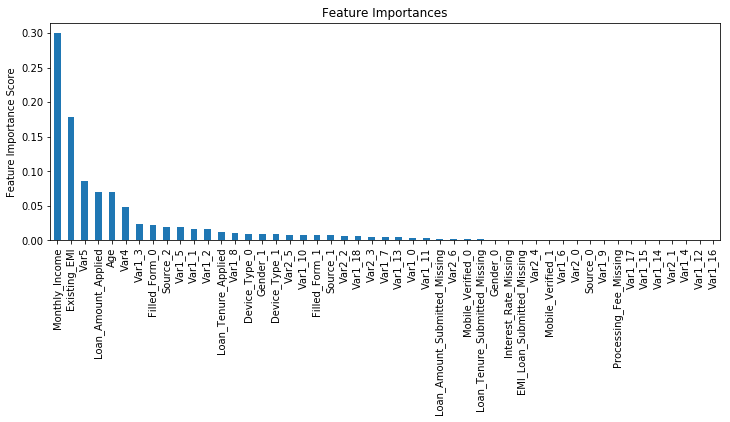

In [17]:
#Choose all predictors except target & IDcols
predictors = [x for x in train.columns if x not in [target, IDcol]]
gbm0 = GradientBoostingClassifier(random_state=10)
modelfit(gbm0, train, predictors)

In [29]:
#Choose all predictors except target & IDcols
predictors = [x for x in train.columns if x not in [target, IDcol]]
param_test1 = {'n_estimators':np.arange(20,81,10)}
gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, min_samples_split=500,min_samples_leaf=50,max_depth=8,max_features='sqrt',subsample=0.8,random_state=10), 
param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(train[predictors],train[target])

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=8,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=50, min_samples_split=500,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=10, subsample=0.8, verbose=0,
              warm_start=False),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'n_estimators': array([20, 30, 40, 50, 60, 70, 80])},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [30]:
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: 0.83337, std: 0.00991, params: {'n_estimators': 20},
  mean: 0.83697, std: 0.00994, params: {'n_estimators': 30},
  mean: 0.83832, std: 0.01050, params: {'n_estimators': 40},
  mean: 0.83867, std: 0.01081, params: {'n_estimators': 50},
  mean: 0.83939, std: 0.01077, params: {'n_estimators': 60},
  mean: 0.83891, std: 0.01044, params: {'n_estimators': 70},
  mean: 0.83807, std: 0.01093, params: {'n_estimators': 80}],
 {'n_estimators': 60},
 0.8393880266861308)

In [32]:
param_test2 = {'max_depth':np.arange(5,16,2), 'min_samples_split':np.arange(200,1001,200)}
gsearch2 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=60, max_features='sqrt', subsample=0.8, random_state=10), 
param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2.fit(train[predictors],train[target])
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

([mean: 0.83297, std: 0.01226, params: {'max_depth': 5, 'min_samples_split': 200},
  mean: 0.83251, std: 0.01054, params: {'max_depth': 5, 'min_samples_split': 400},
  mean: 0.83386, std: 0.01415, params: {'max_depth': 5, 'min_samples_split': 600},
  mean: 0.83379, std: 0.01169, params: {'max_depth': 5, 'min_samples_split': 800},
  mean: 0.83339, std: 0.01266, params: {'max_depth': 5, 'min_samples_split': 1000},
  mean: 0.83365, std: 0.00787, params: {'max_depth': 7, 'min_samples_split': 200},
  mean: 0.83663, std: 0.00991, params: {'max_depth': 7, 'min_samples_split': 400},
  mean: 0.83480, std: 0.00828, params: {'max_depth': 7, 'min_samples_split': 600},
  mean: 0.83786, std: 0.01067, params: {'max_depth': 7, 'min_samples_split': 800},
  mean: 0.83769, std: 0.01060, params: {'max_depth': 7, 'min_samples_split': 1000},
  mean: 0.83581, std: 0.01003, params: {'max_depth': 9, 'min_samples_split': 200},
  mean: 0.83729, std: 0.00959, params: {'max_depth': 9, 'min_samples_split': 400},
  

In [33]:
param_test3 = {'min_samples_leaf':np.arange(30,71,10)}
gsearch3 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, min_samples_split=800, n_estimators=60,max_depth=9,max_features='sqrt', subsample=0.8, random_state=10), 
param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch3.fit(train[predictors],train[target])
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

([mean: 0.83821, std: 0.01128, params: {'min_samples_leaf': 30},
  mean: 0.83701, std: 0.01214, params: {'min_samples_leaf': 40},
  mean: 0.83670, std: 0.01234, params: {'min_samples_leaf': 50},
  mean: 0.83540, std: 0.01209, params: {'min_samples_leaf': 60},
  mean: 0.83623, std: 0.01187, params: {'min_samples_leaf': 70}],
 {'min_samples_leaf': 30},
 0.8382128706279215)

In [34]:
param_test3 = {'min_samples_leaf':np.arange(10,31,5)}
gsearch3 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, min_samples_split=800, n_estimators=60,max_depth=9,max_features='sqrt', subsample=0.8, random_state=10), 
param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch3.fit(train[predictors],train[target])
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

([mean: 0.83720, std: 0.01058, params: {'min_samples_leaf': 10},
  mean: 0.83753, std: 0.01217, params: {'min_samples_leaf': 15},
  mean: 0.83935, std: 0.01015, params: {'min_samples_leaf': 20},
  mean: 0.83621, std: 0.00946, params: {'min_samples_leaf': 25},
  mean: 0.83821, std: 0.01128, params: {'min_samples_leaf': 30}],
 {'min_samples_leaf': 20},
 0.8393453109107563)


Model Report
Accuracy : 0.9854
AUC Score (Train): 0.905067
CV Score : Mean - 0.8393453 | Std - 0.0101461 | Min - 0.8281487 | Max - 0.8521743


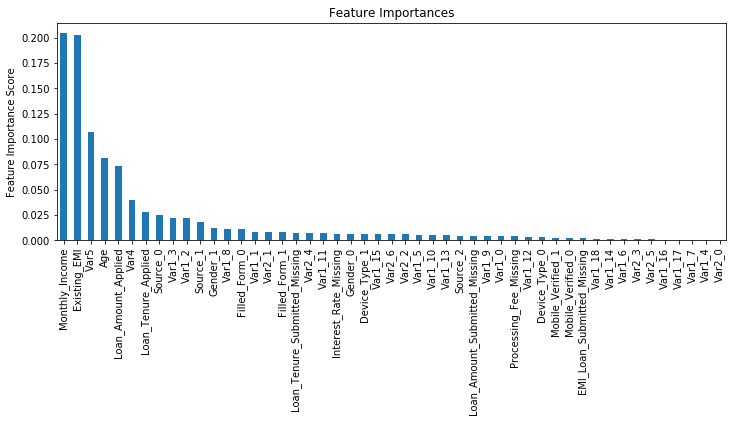

In [35]:
modelfit(gsearch3.best_estimator_, train, predictors)

In [37]:
param_test4 = {'max_features':np.arange(7,20,2)}
gsearch4 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=60,max_depth=9, min_samples_split=800, min_samples_leaf=20, subsample=0.8, random_state=10),
param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch4.fit(train[predictors],train[target])
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

([mean: 0.83935, std: 0.01015, params: {'max_features': 7},
  mean: 0.83637, std: 0.01110, params: {'max_features': 9},
  mean: 0.83573, std: 0.00939, params: {'max_features': 11},
  mean: 0.83528, std: 0.00922, params: {'max_features': 13},
  mean: 0.83733, std: 0.00874, params: {'max_features': 15},
  mean: 0.83534, std: 0.01013, params: {'max_features': 17},
  mean: 0.83671, std: 0.00887, params: {'max_features': 19}],
 {'max_features': 7},
 0.8393453109107563)

In [38]:
param_test4 = {'max_features':np.arange(1,8,2)}
gsearch4 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=60,max_depth=9, min_samples_split=800, min_samples_leaf=20, subsample=0.8, random_state=10),
param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch4.fit(train[predictors],train[target])
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

([mean: 0.82383, std: 0.01280, params: {'max_features': 1},
  mean: 0.83430, std: 0.01253, params: {'max_features': 3},
  mean: 0.83627, std: 0.01026, params: {'max_features': 5},
  mean: 0.83935, std: 0.01015, params: {'max_features': 7}],
 {'max_features': 7},
 0.8393453109107563)

In [39]:
param_test5 = {'subsample':[0.6,0.7,0.75,0.8,0.85,0.9]}
gsearch5 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=60,max_depth=9,min_samples_split=800, min_samples_leaf=20, subsample=0.8, random_state=10,max_features=7),
param_grid = param_test5, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch5.fit(train[predictors],train[target])
gsearch5.grid_scores_, gsearch5.best_params_, gsearch5.best_score_

([mean: 0.83469, std: 0.00839, params: {'subsample': 0.6},
  mean: 0.83565, std: 0.01000, params: {'subsample': 0.7},
  mean: 0.83594, std: 0.01129, params: {'subsample': 0.75},
  mean: 0.83935, std: 0.01015, params: {'subsample': 0.8},
  mean: 0.83714, std: 0.00963, params: {'subsample': 0.85},
  mean: 0.83642, std: 0.01229, params: {'subsample': 0.9}],
 {'subsample': 0.8},
 0.8393453109107563)


Model Report
Accuracy : 0.9854
AUC Score (Train): 0.905067
CV Score : Mean - 0.8393453 | Std - 0.0101461 | Min - 0.8281487 | Max - 0.8521743


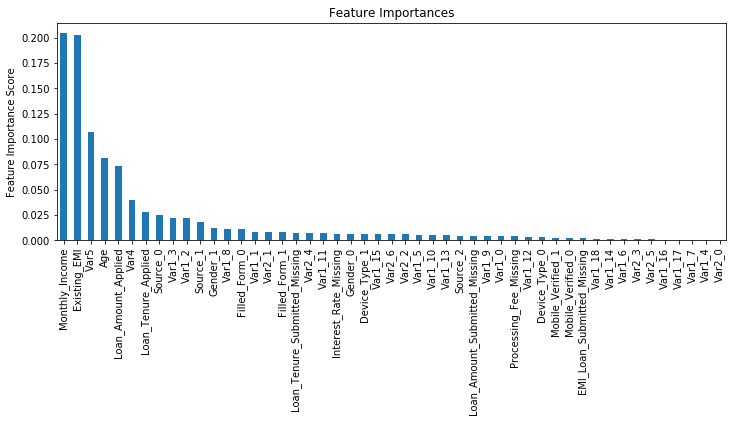

In [40]:
predictors = [x for x in train.columns if x not in [target, IDcol]]
gbm_tuned_1 = GradientBoostingClassifier(learning_rate=0.1, n_estimators=60,max_depth=9, min_samples_split=800,min_samples_leaf=20, subsample=0.8, random_state=10, max_features=7)
modelfit(gbm_tuned_1, train, predictors)


Model Report
Accuracy : 0.9854
AUC Score (Train): 0.906667
CV Score : Mean - 0.8400826 | Std - 0.01109735 | Min - 0.823323 | Max - 0.8525406


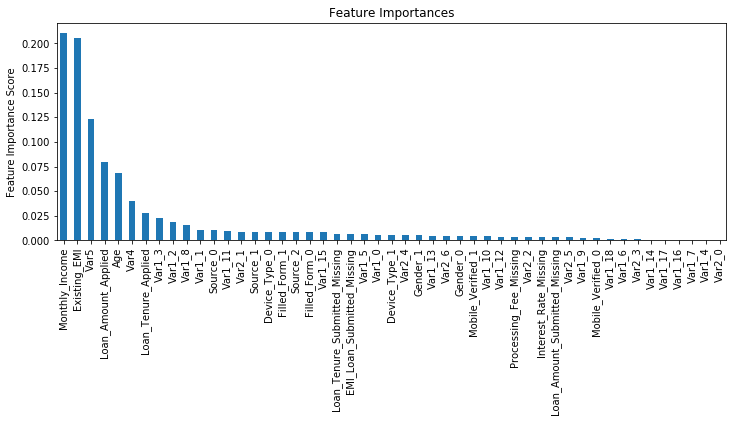

In [41]:
predictors = [x for x in train.columns if x not in [target, IDcol]]
gbm_tuned_1 = GradientBoostingClassifier(learning_rate=0.05, n_estimators=120,max_depth=9, min_samples_split=800,min_samples_leaf=20, subsample=0.8, random_state=10, max_features=7)
modelfit(gbm_tuned_1, train, predictors)


Model Report
Accuracy : 0.9854
AUC Score (Train): 0.909643
CV Score : Mean - 0.8406338 | Std - 0.009506437 | Min - 0.8269343 | Max - 0.8518824


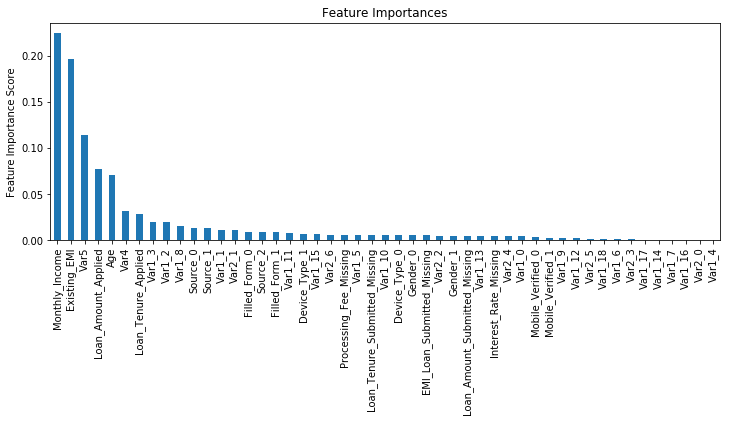

In [42]:
predictors = [x for x in train.columns if x not in [target, IDcol]]
gbm_tuned_1 = GradientBoostingClassifier(learning_rate=0.01, n_estimators=600,max_depth=9, min_samples_split=800,min_samples_leaf=20, subsample=0.8, random_state=10, max_features=7)
modelfit(gbm_tuned_1, train, predictors)


Model Report
Accuracy : 0.9854
AUC Score (Train): 0.910531
CV Score : Mean - 0.8413604 | Std - 0.009830646 | Min - 0.8277482 | Max - 0.8529638


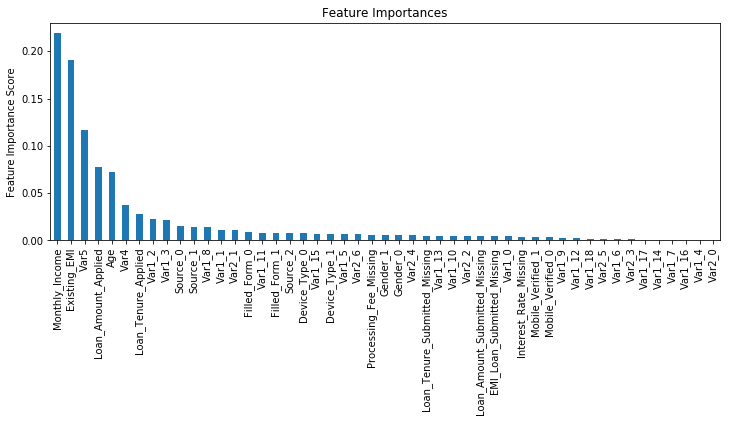

In [43]:
predictors = [x for x in train.columns if x not in [target, IDcol]]
gbm_tuned_1 = GradientBoostingClassifier(learning_rate=0.005, n_estimators=1200,max_depth=9, min_samples_split=800,min_samples_leaf=20, subsample=0.8, random_state=10, max_features=7)
modelfit(gbm_tuned_1, train, predictors)


Model Report
Accuracy : 0.9854
AUC Score (Train): 0.916175
CV Score : Mean - 0.841262 | Std - 0.01011228 | Min - 0.8270307 | Max - 0.854002


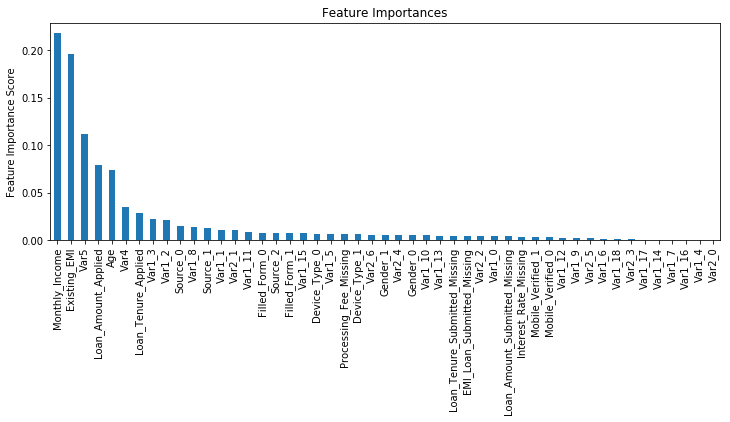

In [45]:
predictors = [x for x in train.columns if x not in [target, IDcol]]
gbm_tuned_1 = GradientBoostingClassifier(learning_rate=0.005, n_estimators=1500,max_depth=9, min_samples_split=800,min_samples_leaf=20, subsample=0.8, random_state=10, max_features=7)
modelfit(gbm_tuned_1, train, predictors)